
🔍 Running GridSearch for Logistic Regression...
✅ Best Recall for Logistic Regression: 0.8894
   Best Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 4}}

🔍 Running GridSearch for Random Forest...
✅ Best Recall for Random Forest: 0.8457
   Best Parameters: {'class_weight': 'balanced', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}

🔍 Running GridSearch for XGBoost...
✅ Best Recall for XGBoost: 0.9107
   Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 500, 'scale_pos_weight': 6, 'subsample': 0.7}

🔍 Running GridSearch for Gradient Boosting...
✅ Best Recall for Gradient Boosting: 0.8772
   Best Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.8}

🔍 Running GridSearch for Polynomial Logistic Regression...
✅ Best Recall for Polynomial Logistic Regression: 0.8802
   Best Parameters: {'logisticregression__C': 0.1, 'logisticregression__class_

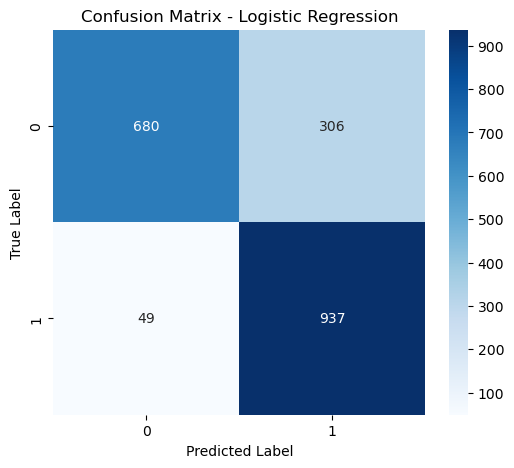

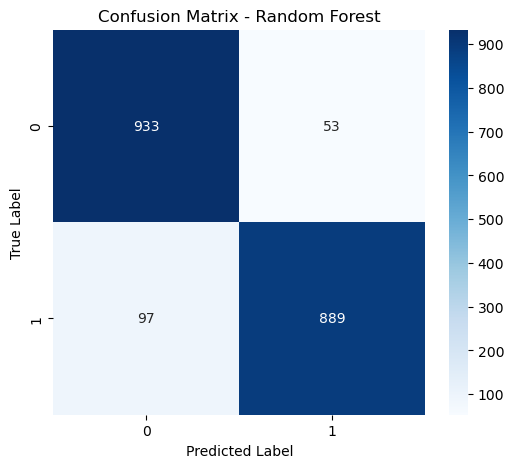

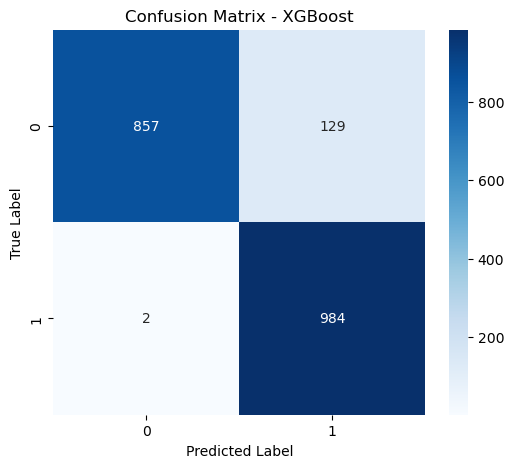

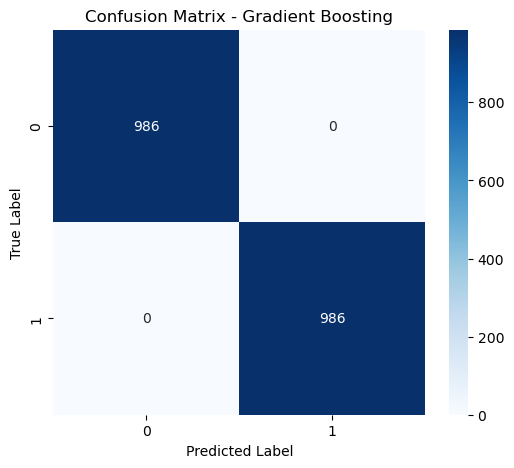

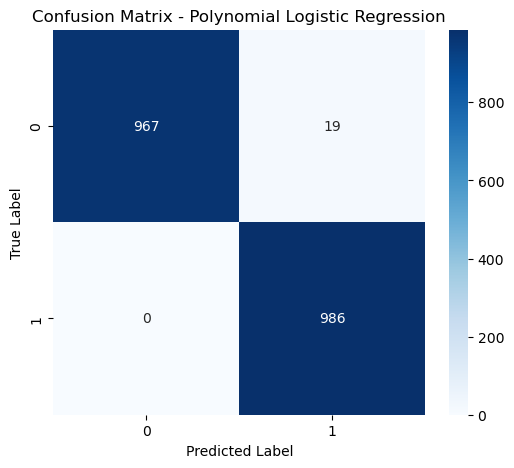

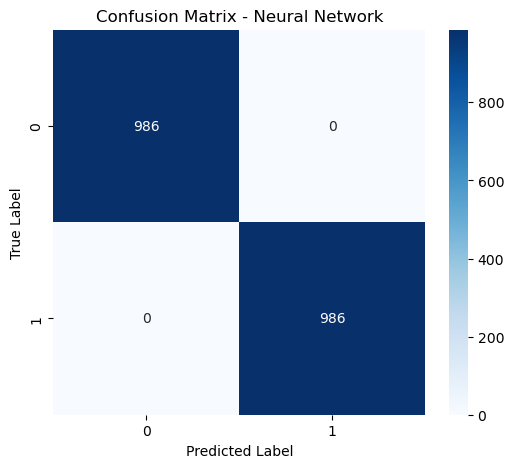

                                 TN   FP  FN   TP
Logistic Regression             680  306  49  937
Random Forest                   933   53  97  889
XGBoost                         857  129   2  984
Gradient Boosting               986    0   0  986
Polynomial Logistic Regression  967   19   0  986
Neural Network                  986    0   0  986


In [12]:
# Re-import necessary libraries after execution state reset
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE



# 🚀 Load Data
file_path = "Employee_attrition.csv"  # Update with the correct path
df = pd.read_csv(file_path)

# Drop unnecessary columns
drop_cols = ["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"]
df.drop(columns=drop_cols, inplace=True, errors="ignore")

# Convert 'Attrition' (target variable) to binary
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Remove low-importance features
drop_low_importance = [
    "EducationField_Other", "JobRole_Human Resources", "PerformanceRating", "JobRole_Manager",
    "JobRole_Sales Representative", "EducationField_Technical Degree", "EducationField_Marketing",
    "EducationField_Medical"
]
df.drop(columns=[col for col in drop_low_importance if col in df.columns], inplace=True, errors="ignore")

# Split data into train & test
X = df.drop("Attrition", axis=1)
y = df["Attrition"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# 🚀 Updated Hyperparameter Grids with Overfitting Prevention
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(solver="liblinear", max_iter=500),
        "params": {
            "C": [0.1, 1],  # Stronger regularization
            "class_weight": [{0: 1, 1: 3}, {0: 1, 1: 4}]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [200, 500],
            "max_depth": [4, 6],  # Reduced depth for generalization
            "min_samples_split": [10, 20],  # Minimum split enforcement
            "min_samples_leaf": [5, 10],  # Prevents tiny leaf nodes
            "class_weight": ["balanced"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42),
        "params": {
            "n_estimators": [500],
            "max_depth": [4, 6],  # Lowered to prevent memorization
            "learning_rate": [0.02, 0.05],  # Lower learning rate
            "colsample_bytree": [0.7, 0.8],  # Adds randomness
            "subsample": [0.7, 0.8],  # Prevents full dataset memorization
            "scale_pos_weight": [5, 6],  # Adjust for imbalance
            "min_child_weight": [5, 10]  # Prevents tiny splits
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [500],
            "max_depth": [4, 6],  # Reduced complexity
            "learning_rate": [0.02, 0.05],  # Smaller steps
            "subsample": [0.8]  # Prevents full dataset memorization
        }
    },
    "Polynomial Logistic Regression": {
        "model": make_pipeline(PolynomialFeatures(), LogisticRegression(solver="liblinear", max_iter=500)),
        "params": {
            "polynomialfeatures__degree": [2],  # Prevents excessive feature expansion
            "logisticregression__C": [0.1, 1],  # Stronger regularization
            "logisticregression__class_weight": [{0: 1, 1: 3}, {0: 1, 1: 4}]
        }
    },
    "Neural Network": {
        "model": MLPClassifier(max_iter=500, random_state=42),
        "params": {
            "hidden_layer_sizes": [(64, 32)],  # Reduced complexity
            "activation": ["relu"],
            "solver": ["adam"],
            "alpha": [0.01, 0.001]  # L2 regularization to prevent overfitting
        }
    }
}

# 🚀 Run GridSearch for Each Model (Optimizing for Recall)
best_models = {}
for model_name, model_info in param_grids.items():
    print(f"\n🔍 Running GridSearch for {model_name}...")
    grid_search = GridSearchCV(model_info["model"], model_info["params"], scoring="recall", cv=5, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_smote)
    
    best_models[model_name] = {
        "best_estimator": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }

    print(f"✅ Best Recall for {model_name}: {grid_search.best_score_:.4f}")
    print(f"   Best Parameters: {grid_search.best_params_}")

# 🚀 Find the Best Model Based on Recall
best_model_name = max(best_models, key=lambda k: best_models[k]["best_score"])
best_model = best_models[best_model_name]

# 🚀 Evaluate the Best Model on the Test Set
y_pred_best = best_model["best_estimator"].predict(X_test_scaled)
report = classification_report(y_test, y_pred_best, output_dict=True)

# 🚀 Extract Final Metrics
final_metrics = {
    "Model": best_model_name,
    "Recall (Attrition=1)": report["1"]["recall"],
    "Precision (Attrition=1)": report["1"]["precision"],
    "F1-Score (Attrition=1)": report["1"]["f1-score"],
    "Accuracy": report["accuracy"]
}

# 🚀 Display the Results
df_final_results = pd.DataFrame([final_metrics])
print(df_final_results)

# 🚀 Generate and Save Confusion Matrices
conf_matrix_dir = "confusion_matrices"
os.makedirs(conf_matrix_dir, exist_ok=True)

conf_matrices = {}

for model_name, model_info in best_models.items():
    model = model_info["best_estimator"]
    y_pred = model.predict(X_train_scaled)
    cm = confusion_matrix(y_train_smote, y_pred)
    conf_matrices[model_name] = cm

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    
    cm_filename = os.path.join(conf_matrix_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_filename)
    plt.show()

df_conf_matrices = pd.DataFrame.from_dict(
    {model: cm.flatten() for model, cm in conf_matrices.items()}, 
    orient="index", 
    columns=["TN", "FP", "FN", "TP"]
)

print(df_conf_matrices)


In [20]:
# 🚀 Evaluate All Models on the Test Set and Store Performance
test_results = []

for model_name, model_info in best_models.items():
    model = model_info["best_estimator"]
    y_pred_test = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred_test, output_dict=True)
    
    test_results.append({
        "Model": model_name,
        "Recall (Test - Attrition=1)": report["1"]["recall"],
        "Precision (Test - Attrition=1)": report["1"]["precision"],
        "F1-Score (Test - Attrition=1)": report["1"]["f1-score"],
        "Accuracy (Test)": report["accuracy"]
    })

# Convert results to DataFrame
df_test_results = pd.DataFrame(test_results)

# Display the test performance results

print(df_test_results)


                            Model  Recall (Test - Attrition=1)  \
0             Logistic Regression                     0.617021   
1                   Random Forest                     0.468085   
2                         XGBoost                     0.574468   
3               Gradient Boosting                     0.297872   
4  Polynomial Logistic Regression                     0.510638   
5                  Neural Network                     0.382979   

   Precision (Test - Attrition=1)  F1-Score (Test - Attrition=1)  \
0                        0.271028                       0.376623   
1                        0.415094                       0.440000   
2                        0.329268                       0.418605   
3                        0.500000                       0.373333   
4                        0.342857                       0.410256   
5                        0.367347                       0.375000   

   Accuracy (Test)  
0         0.673469  
1         0.809524

In [22]:
# 🚀 Improved Hyperparameter Grids for Higher Recall in All Models
param_grids_improved = {
    "Logistic Regression": {
        "model": LogisticRegression(solver="liblinear", max_iter=500),
        "params": {
            "C": [0.05, 0.1, 0.5],  # Adjust regularization for better recall
            "class_weight": [{0: 1, 1: 5}, {0: 1, 1: 6}, {0: 1, 1: 7}]  # Increase weight for attrition cases
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [300, 500],
            "max_depth": [6, 8],  # Balanced depth to reduce overfitting
            "min_samples_split": [10, 20],
            "min_samples_leaf": [5, 10],
            "class_weight": ["balanced"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [600, 800],  # More boosting rounds
            "max_depth": [4, 6],  # Lowered for better generalization
            "learning_rate": [0.02, 0.03],  # Smaller steps
            "colsample_bytree": [0.7, 0.8],
            "subsample": [0.7, 0.8],
            "scale_pos_weight": [6, 8],  # Stronger imbalance handling
            "min_child_weight": [5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [600, 800],
            "max_depth": [4, 6],
            "learning_rate": [0.02, 0.03],
            "subsample": [0.7, 0.8]
        }
    },
    "Polynomial Logistic Regression": {
        "model": make_pipeline(PolynomialFeatures(), LogisticRegression(solver="liblinear", max_iter=500)),
        "params": {
            "polynomialfeatures__degree": [2],
            "logisticregression__C": [0.05, 0.1, 0.5],  # Stronger regularization
            "logisticregression__class_weight": [{0: 1, 1: 5}, {0: 1, 1: 6}]
        }
    },
    "Neural Network": {
        "model": MLPClassifier(max_iter=600, random_state=42),
        "params": {
            "hidden_layer_sizes": [(64, 32), (128, 64)],
            "activation": ["relu"],
            "solver": ["adam"],
            "alpha": [0.001, 0.0005]  # Stronger L2 regularization
        }
    }
}

# 🚀 Run GridSearch for Each Model (Optimizing for Higher Recall)
best_models_improved = {}
for model_name, model_info in param_grids_improved.items():
    print(f"\n🔍 Running Improved GridSearch for {model_name}...")
    grid_search = GridSearchCV(model_info["model"], model_info["params"], scoring="recall", cv=5, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_smote)
    
    best_models_improved[model_name] = {
        "best_estimator": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }

    print(f"✅ Best Recall for {model_name}: {grid_search.best_score_:.4f}")
    print(f"   Best Parameters: {grid_search.best_params_}")

# 🚀 Evaluate the Best Models on the Test Set with Improved Settings
test_results_improved = []
for model_name, model_info in best_models_improved.items():
    model = model_info["best_estimator"]
    y_pred_test = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred_test, output_dict=True)
    
    test_results_improved.append({
        "Model": model_name,
        "Recall (Test - Attrition=1)": report["1"]["recall"],
        "Precision (Test - Attrition=1)": report["1"]["precision"],
        "F1-Score (Test - Attrition=1)": report["1"]["f1-score"],
        "Accuracy (Test)": report["accuracy"]
    })

# Convert results to DataFrame
df_test_results_improved = pd.DataFrame(test_results_improved)

print(df_test_results_improved)



🔍 Running Improved GridSearch for Logistic Regression...
✅ Best Recall for Logistic Regression: 0.9066
   Best Parameters: {'C': 0.05, 'class_weight': {0: 1, 1: 7}}

🔍 Running Improved GridSearch for Random Forest...
✅ Best Recall for Random Forest: 0.8539
   Best Parameters: {'class_weight': 'balanced', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}

🔍 Running Improved GridSearch for XGBoost...
✅ Best Recall for XGBoost: 0.9137
   Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.02, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 600, 'scale_pos_weight': 8, 'subsample': 0.7}

🔍 Running Improved GridSearch for Gradient Boosting...
✅ Best Recall for Gradient Boosting: 0.8822
   Best Parameters: {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.7}

🔍 Running Improved GridSearch for Polynomial Logistic Regression...
✅ Best Recall for Polynomial Logistic Regression: 0.8883
   Best Parameters: {'logisticre

In [24]:
from sklearn.ensemble import VotingClassifier

# 🚀 Create an Ensemble Model: Logistic Regression + XGBoost
best_log_reg = best_models_improved["Logistic Regression"]["best_estimator"]
best_xgb = best_models_improved["XGBoost"]["best_estimator"]

# Define a voting classifier with soft voting (probability-based)
ensemble_model = VotingClassifier(
    estimators=[
        ("Logistic Regression", best_log_reg),
        ("XGBoost", best_xgb)
    ],
    voting="soft"  # Uses probabilities to make predictions
)

# Train the ensemble model
ensemble_model.fit(X_train_scaled, y_train_smote)

# Predict on test set
y_pred_ensemble = ensemble_model.predict(X_test_scaled)
report_ensemble = classification_report(y_test, y_pred_ensemble, output_dict=True)

# Extract performance metrics
ensemble_results = {
    "Model": "Ensemble (LogReg + XGBoost)",
    "Recall (Test - Attrition=1)": report_ensemble["1"]["recall"],
    "Precision (Test - Attrition=1)": report_ensemble["1"]["precision"],
    "F1-Score (Test - Attrition=1)": report_ensemble["1"]["f1-score"],
    "Accuracy (Test)": report_ensemble["accuracy"]
}

# Convert results to DataFrame
df_ensemble_results = pd.DataFrame([ensemble_results])

print(df_ensemble_results)


                         Model  Recall (Test - Attrition=1)  \
0  Ensemble (LogReg + XGBoost)                     0.680851   

   Precision (Test - Attrition=1)  F1-Score (Test - Attrition=1)  \
0                        0.296296                       0.412903   

   Accuracy (Test)  
0         0.690476  


In [28]:
# 🚀 Fine-Tuning the Decision Threshold for the Ensemble Model

# Get predicted probabilities for the positive class (Attrition=1)
y_pred_prob_ensemble = ensemble_model.predict_proba(X_test_scaled)[:, 1]

# Define a new threshold for classification (Lowering from 0.5 to improve recall)
best_threshold = 0.35

# Apply the new threshold to make predictions
y_pred_ensemble_adjusted = (y_pred_prob_ensemble >= best_threshold).astype(int)

# Evaluate the adjusted predictions
report_ensemble_adjusted = classification_report(y_test, y_pred_ensemble_adjusted, output_dict=True)

# Extract performance metrics after threshold tuning
ensemble_results_adjusted = {
    "Model": f"Ensemble (Threshold {best_threshold})",
    "Recall (Test - Attrition=1)": report_ensemble_adjusted["1"]["recall"],
    "Precision (Test - Attrition=1)": report_ensemble_adjusted["1"]["precision"],
    "F1-Score (Test - Attrition=1)": report_ensemble_adjusted["1"]["f1-score"],
    "Accuracy (Test)": report_ensemble_adjusted["accuracy"]
}

# Convert results to DataFrame
df_ensemble_results_adjusted = pd.DataFrame([ensemble_results_adjusted])

print(df_ensemble_results_adjusted)


                       Model  Recall (Test - Attrition=1)  \
0  Ensemble (Threshold 0.35)                     0.765957   

   Precision (Test - Attrition=1)  F1-Score (Test - Attrition=1)  \
0                        0.230769                        0.35468   

   Accuracy (Test)  
0         0.554422  


We will try stacking the models now

In [33]:
from sklearn.ensemble import StackingClassifier

# 🚀 Create a Stacking Model: Logistic Regression + XGBoost with a Meta-Model
meta_model = LogisticRegression(solver="liblinear", max_iter=500, class_weight={0: 1, 1: 6})

stacking_model = StackingClassifier(
    estimators=[
        ("Logistic Regression", best_log_reg),
        ("XGBoost", best_xgb)
    ],
    final_estimator=meta_model,  # Logistic Regression as the meta-model
    passthrough=True  # Allows base models' predictions as additional features
)

# Train the stacking model
stacking_model.fit(X_train_scaled, y_train_smote)

# Predict on test set using the stacking model
y_pred_stacking = stacking_model.predict(X_test_scaled)
report_stacking = classification_report(y_test, y_pred_stacking, output_dict=True)

# Extract performance metrics
stacking_results = {
    "Model": "Stacking (LogReg + XGBoost)",
    "Recall (Test - Attrition=1)": report_stacking["1"]["recall"],
    "Precision (Test - Attrition=1)": report_stacking["1"]["precision"],
    "F1-Score (Test - Attrition=1)": report_stacking["1"]["f1-score"],
    "Accuracy (Test)": report_stacking["accuracy"]
}

# Convert results to DataFrame
df_stacking_results = pd.DataFrame([stacking_results])

# Display the stacking model performance
print(df_stacking_results)


                         Model  Recall (Test - Attrition=1)  \
0  Stacking (LogReg + XGBoost)                     0.489362   

   Precision (Test - Attrition=1)  F1-Score (Test - Attrition=1)  \
0                        0.348485                        0.40708   

   Accuracy (Test)  
0         0.772109  


Recall reduced drastically therfore we will stick with our first ensemble model with recall that was more reasonable and accept the high false positive rate since our primary goal is to identify people that might leave and not save resources by only going for people who certainly leave

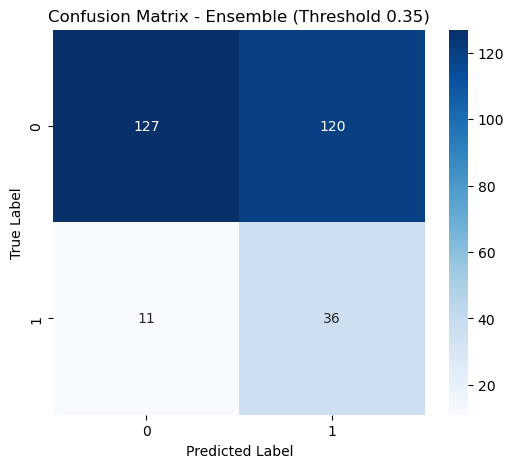

In [36]:
cm_ensemble_adjusted = confusion_matrix(y_test, y_pred_ensemble_adjusted)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ensemble_adjusted, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Ensemble (Threshold {best_threshold})")
plt.show()
